In [1]:
import os
from datetime import datetime
from pprint import pprint
from typing import List
import string
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union
import app
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from shapely.geometry import Point

# 0. Import

In [2]:
data_folder = r"D:\[Code]\HydrofractureShackleton_2023\data"
data_dmg_folder = r"D:\[Code]\HydrofractureShackleton_2023\data-dmg"
data_img_folder = r"D:\[Code]\HydrofractureShackleton_2023\data-img"
figure_folder = r"D:\[Code]\HydrofractureShackleton_2023\figures"

In [3]:
path = os.path.join(data_folder, r"shackleton_hydrofractures.xlsx")
events_raw = pd.read_excel(path, index_col=0).query("comment != 'refreeze'")
events_raw["geometry"] = gpd.GeoSeries.from_wkt(events_raw["geom_centroid_4326"])
events = gpd.GeoDataFrame(events_raw, geometry="geometry")  # type: ignore
events.set_crs("EPSG:4326", inplace=True)
events.sort_values("lon", inplace=True)
events.reset_index(drop=True, inplace=True)
events.to_crs("EPSG:3031", inplace=True)
events["label"] = list(string.ascii_uppercase)[: len(events)]
events["summer"] = [app.determine_antarctic_summer(d) for d in events["date-0 vis"]]
events["volume-1 m^3"] = np.nan_to_num(x=events["volume-1 m^3"].values, nan=0)  # type: ignore
events

,lon,lat,lake,tile,date-0,sat-0,start-0,end-0,meandepth-0 m,volume-0 m^3,...,volume-1 m^3,sat-1 vis,date-1 vis,comment,geom_centroid_4326,geom_lake0_3031,geom_lake1_3031,geometry,label,summer
0,95.688019,-66.671201,105,183,2019-12-21,L8,2019-12-17,2019-12-25,0.972973,64799.986267,...,0.000000,S1,2019-12-27,NaN,POINT (95.68801944620978 -66.67120140922434),"POLYGON ((2557200 -256740, 2557290 -256740, 25...","POLYGON ((2557200 -256920, 2557260 -256920, 25...",POINT (2556275.678 -254610.402),A,2019
1,95.737264,-66.660983,97,183,2019-12-21,L8,2019-12-17,2019-12-25,1.139460,63581.877136,...,1742.883110,S1,2019-12-25,NaN,POINT (95.73726398795348 -66.66098334842171),"POLYGON ((2556180 -254280, 2556210 -254280, 25...",NaN,POINT (2557205.807 -256922.905),B,2019
2,95.759349,-66.646830,428,182,2020-01-06,L8,2020-01-02,2020-01-10,0.569657,64086.362457,...,6092.188454,S1,2020-01-11,NaN,POINT (95.75934933544644 -66.64682963582811),"POLYGON ((2555160 -447840, 2555250 -447840, 25...","MULTIPOLYGON (((2555400 -447930, 2555460 -4479...",POINT (2558699.399 -258069.242),C,2019
3,97.781752,-66.594966,56,182,2018-12-26,S2,2018-12-21,2018-12-31,0.633600,80023.718262,...,0.000000,L8,2019-01-05,NaN,POINT (97.781752069401 -66.59496564096317),"MULTIPOLYGON (((2554470 -349110, 2554500 -3491...",NaN,POINT (2553811.141 -349000.031),D,2018
4,98.104002,-66.492315,194,182,2020-02-04,S2,2020-01-30,2020-02-09,1.125474,109621.166992,...,5646.196747,S2,2020-02-03,NaN,POINT (98.10400213133633 -66.49231534293904),"POLYGON ((2563200 -364800, 2563260 -364800, 25...","MULTIPOLYGON (((2563260 -365040, 2563320 -3650...",POINT (2563306.902 -364995.272),E,2019
5,98.493578,-65.782618,614,182,2020-01-05,S2,2019-12-31,2020-01-10,0.583205,30501.635742,...,0.000000,S1,2020-01-08,NaN,POINT (98.49357799572716 -65.78261844755363),"MULTIPOLYGON (((2573070 -395850, 2573100 -3958...","MULTIPOLYGON (((2573040 -395880, 2573100 -3958...",POINT (2640302.345 -394293.286),F,2019
6,98.870325,-66.357777,358,182,2020-01-22,L8,2020-01-18,2020-01-26,0.767080,71798.723602,...,7308.135509,S1,2020-01-27,NaN,POINT (98.87032524604828 -66.35777722797837),"POLYGON ((2573340 -401340, 2573400 -401340, 25...","MULTIPOLYGON (((2573220 -401790, 2573280 -4017...",POINT (2573243.364 -401593.846),G,2019
7,99.719303,-66.264245,190,182,2020-01-06,L8,2020-01-02,2020-01-10,0.906136,57902.075958,...,3636.890888,S1,2020-01-11,NaN,POINT (99.7193031471739 -66.26424467999234),"POLYGON ((2577360 -441270, 2577390 -441270, 25...","MULTIPOLYGON (((2577420 -441390, 2577450 -4413...",POINT (2577450.447 -441465.448),H,2019
8,99.784536,-66.442883,931,182,2020-01-22,L8,2020-01-18,2020-01-26,1.456559,81275.990295,...,11201.078224,S1,2020-01-23,NaN,POINT (99.78453576622111 -66.44288327194984),"MULTIPOLYGON (((2557020 -441060, 2557050 -4410...","MULTIPOLYGON (((2557170 -440970, 2557200 -4409...",POINT (2557013.702 -440962.258),I,2019
9,99.855341,-66.446568,1052,182,2020-01-22,L8,2020-01-18,2020-01-26,1.618117,112135.487366,...,0.000000,S1,2020-01-23,NaN,POINT (99.85534096700347 -66.44656788578676),"POLYGON ((2555970 -443850, 2556030 -443850, 25...",NaN,POINT (2556055.907 -444050.452),J,2019


In [4]:
optical_files = [
    f
    for f in os.listdir(data_img_folder)
    if f.endswith(".tif") and f.split("_")[0] == "Optical"
]
sar_files = [
    f
    for f in os.listdir(data_img_folder)
    if f.endswith(".tif") and f.split("_")[0] == "Draining"
]

In [5]:
keys = ["lat", "lon", "Timestamp", "satellite", "file"]
metas = []
for f in optical_files:

    meta_info = f.split("_")[6:9] + [f.split("_")[9].split(".")[0]]
    meta_info[0] = float(meta_info[0])  # type: ignore
    meta_info[1] = float(meta_info[1])  # type: ignore
    meta_info[2] = pd.Timestamp(int(meta_info[2]), unit="ms")  # type: ignore
    meta_info.append(f)
    meta = {k: v for k, v in zip(keys, meta_info)}
    metas.append(meta)
optical = pd.DataFrame(metas)
optical["geometry"] = optical.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
optical = gpd.GeoDataFrame(optical, geometry="geometry") # type: ignore
optical.set_crs("EPSG:4326", inplace=True)
optical.to_crs("EPSG:3031", inplace=True)
optical.sort_values("lon", inplace=True)
optical.reset_index(drop=True, inplace=True)
optical["lat round"] = optical["lat"].round(2)

temp_events = events.copy()
temp_events["lat round"] = events["lat"].round(2)
print()
optical = pd.merge(
    optical, temp_events, left_on="lat round", right_on="lat round", how="left"
)
optical.sort_values("label", inplace=True)
print(optical.label.unique())
optical.columns


['A' 'B' 'C' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' nan]


Index(['lat_x', 'lon_x', 'Timestamp', 'satellite', 'file', 'geometry_x',
       'lat round', 'lon_y', 'lat_y', 'lake', 'tile', 'date-0', 'sat-0',
       'start-0', 'end-0', 'meandepth-0 m', 'volume-0 m^3', 'sat-0 vis',
       'date-0 vis', 'date-1', 'sat-1', 'start-1', 'end-1', 'meandepth-1 m',
       'volume-1 m^3', 'sat-1 vis', 'date-1 vis', 'comment',
       'geom_centroid_4326', 'geom_lake0_3031', 'geom_lake1_3031',
       'geometry_y', 'label', 'summer'],
      dtype='object')

In [6]:
tides = app.load_tide_files(
    [
        os.path.join(data_folder, f)
        for f in os.listdir(data_folder)
        if "tides" in f.lower()
    ]
)

In [7]:
tides["plotting_date"] = tides["date"]
for i_summer, summer in enumerate(tides.summer.unique()):
    tides.loc[tides.summer == summer, "plotting_date"] = tides["date"] + pd.DateOffset(years=2020 - summer)


for i_summer, summer in enumerate(tides.summer.unique()):
    drains_summer = events.query("summer == @summer")
    tides_summer = tides.query("summer == @summer")

    date_list = pd.Series(tides_summer.date).dt.date.tolist()

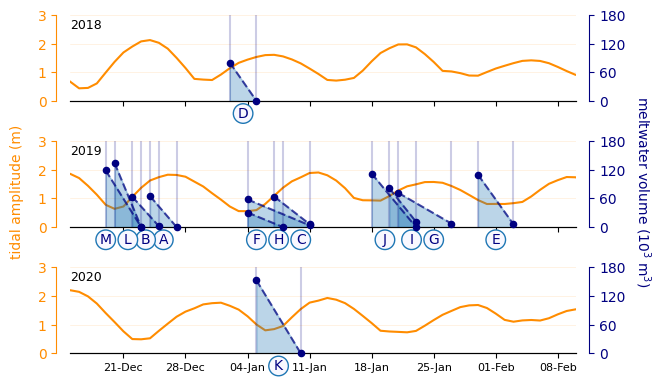

In [9]:
from dateutil.rrule import MO
ymin = 0
ymax = 3
ymax_volume = 180
y_label = -0.2

color_tide = "darkorange"
color_water = "navy"

fig, axes = plt.subplots(3, 1, figsize=(17 / 2.54, 10 / 2.54), sharex=True)
for i_summer, summer in enumerate(tides.summer.unique()):

    events_summer = events.query("summer == @summer").copy()
    tides_summer = tides.query("summer == @summer").copy()

    ax = axes.ravel()[i_summer]
    ax_ = ax.twinx()

    ax.plot(tides_summer.plotting_date, tides_summer.tide, color = color_tide, zorder = 1)
    ax.text(
        x=0, y=0.96, s=summer, transform=ax.transAxes, ha="left", va="top", fontsize=9
    )
    for i_event, (date0, date1, sat0, sat1, volume0, volume1) in enumerate(
        zip(
            events_summer["date-0 vis"],
            events_summer["date-1 vis"],
            events_summer["sat-0 vis"],
            events_summer["sat-1 vis"],
            events_summer["volume-0 m^3"],
            events_summer["volume-1 m^3"],
        )
    ):
        volume0 = volume0 / 1e3
        volume1 = volume1 / 1e3
        days = (date1 - date0).days
        height = volume0 / 5e4 / days

        values = app.interpolate_dates(
            tides_summer, "plotting_date", "tide",
            [
                (date0 + pd.DateOffset(years=2020 - summer)).strftime("%Y-%m-%d"),
                (date1 + pd.DateOffset(years=2020 - summer)).strftime("%Y-%m-%d"),
            ],
        )
        ax_.plot(
            [date0 + pd.DateOffset(years=2020 - summer), 
             date1 + pd.DateOffset(years=2020 - summer)],
            [volume0, volume1],
            color = color_water,
            ls = "--", alpha = 0.7, zorder = 10)

        ax_.scatter(
            date0 + pd.DateOffset(years=2020 - summer),
            volume0,
            color=color_water,
            zorder=10,
            s=20,
            clip_on=False,
        )
        ax_.scatter(
            date1 + pd.DateOffset(years=2020 - summer),
            volume1,
            color=color_water,
            zorder=10,
            s=20,
            clip_on=False,
        )

        ax_.fill_between(
            [date0 + pd.DateOffset(years=2020 - summer), date1 + pd.DateOffset(years=2020 - summer)],
            [0, 0],
            [volume0, volume1],
            color="tab:blue",
            alpha=0.3,
            zorder=1,
        )

        if events_summer["label"].values[i_event] in ["M"]:
            offset = pd.DateOffset(days=-2)
        elif events_summer["label"].values[i_event] in ["F", "P", "J"]:
            offset = pd.DateOffset(days=-1)
        elif events_summer["label"].values[i_event] in ["I", "C", "G"]:
            offset = pd.DateOffset(days=1)
        else: 
            offset = pd.DateOffset(days=0)
        midpoint_timestamp = date0 + (date1 - date0) / 2 + offset
        ax.text(
            midpoint_timestamp + pd.DateOffset(years=2020 - summer),
            y_label,
            events_summer["label"].values[i_event],
            ha="center",
            va="top",
            color="navy",
            bbox=dict(
                edgecolor="tab:blue", facecolor="ghostwhite", boxstyle="circle,pad=0.2"
            ),
        )
        ax.set_ylim(ymin, ymax)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
        ax.tick_params(axis="x", labelsize=8)
        ax.spines.left.set_position(("outward", 10))
        ax.spines.left.set_color(color_tide)
        ax.tick_params(axis="y", colors=color_tide)
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.grid(alpha = 0.2, color = color_tide, zorder = 0, axis = "y", lw = 0.4)

        ax_.set_ylim(0, ymax_volume)
        ax_.yaxis.set_major_locator(ticker.MultipleLocator(60))
        ax_.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
        ax_.spines.right.set_position(("outward", 10))
        ax_.spines.right.set_color(color_water)
        ax_.tick_params(axis="y", colors=color_water)
        ax_.spines.left.set_visible(False)
        ax_.spines.top.set_visible(False)
    for d in pd.concat([events_summer["date-0 vis"], events_summer["date-1 vis"]]).unique():
        ax_.axvline(
            d + pd.DateOffset(years=2020 - summer), ls="-", color=color_water, alpha=0.2, lw = 1.5, zorder = 2
        )

fig.text(0.02, 0.5, r"tidal amplitude (m)", ha="left", va="center", color=color_tide, rotation=90)
fig.text(
    0.98,
    0.5,
    r"meltwater volume ($10^3$ m$^3$)",
    ha="right",
    va="center",
    color=color_water,
    rotation=-90,
)

ax = axes.ravel()[0]
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax.set_xlim([datetime(2020, 12, 15), datetime(2021, 2, 10)])

plt.tight_layout()
plt.subplots_adjust(left=0.11, right=0.865)
fig.savefig(os.path.join(figure_folder, "figure_03.pdf"), dpi=300)
plt.show()